Layer .features.Conv2d0 Sampled 60 units from feature tensor of shape (64, 56, 56)
Gaussian Fitting center (114.9, 115.0)
 Cov mat XX 8.4 YY 9.4 XY -0.0
act mat shape:  (1, 60)
act mat shape:  (1, 60)


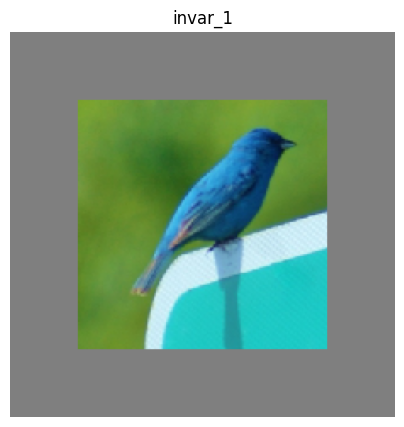

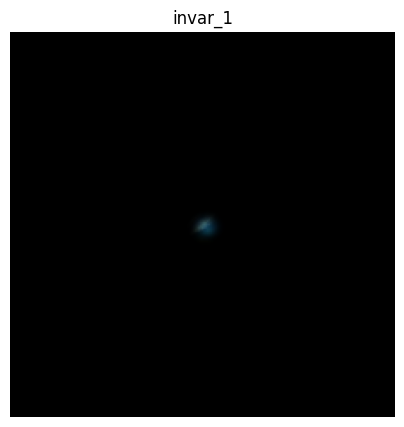

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
:-------------------->  invar_1.JPEG-60-MSE-conv5-fc6 evol finished! best score: -0.832
plot not saved


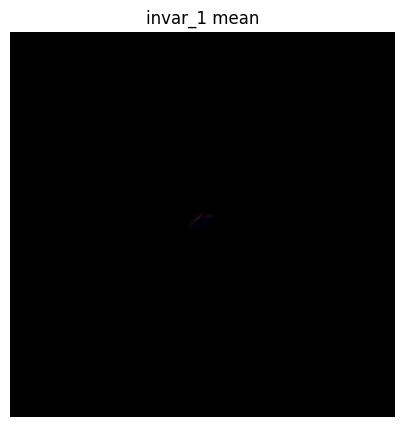

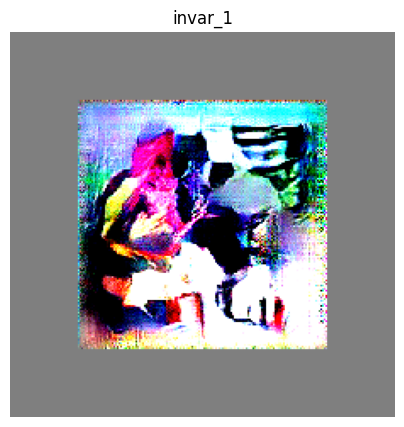

final MSE score:  6.1979136
Cleanuping...
Cleanup hooks done.
Cleanup done.


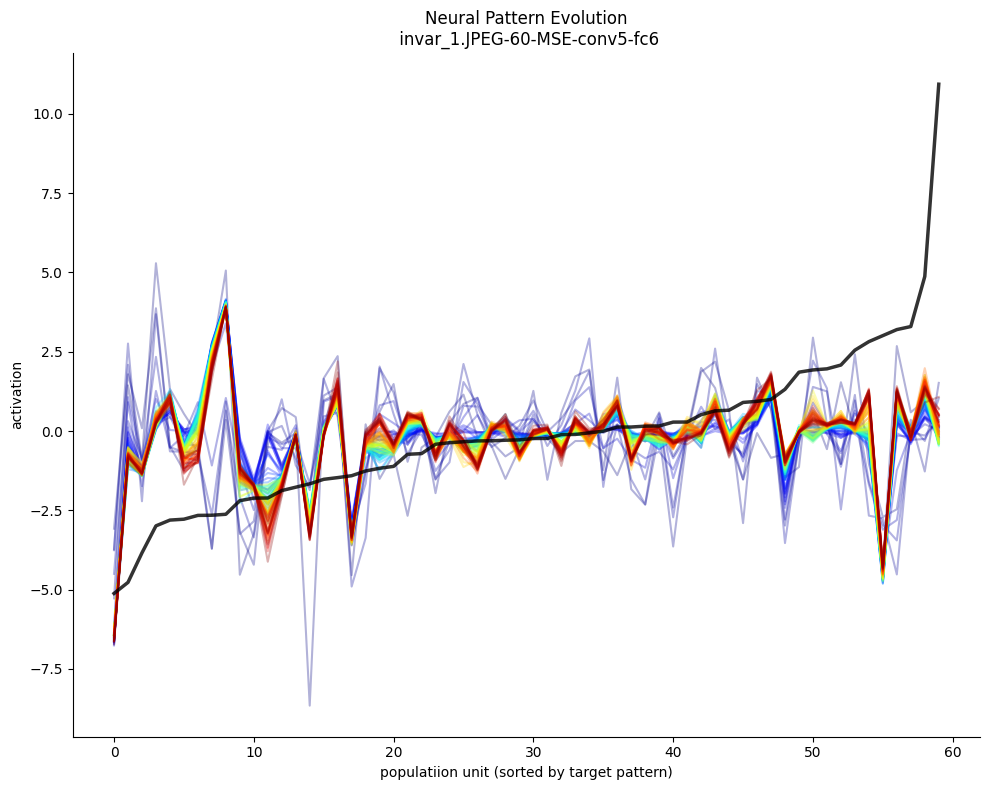

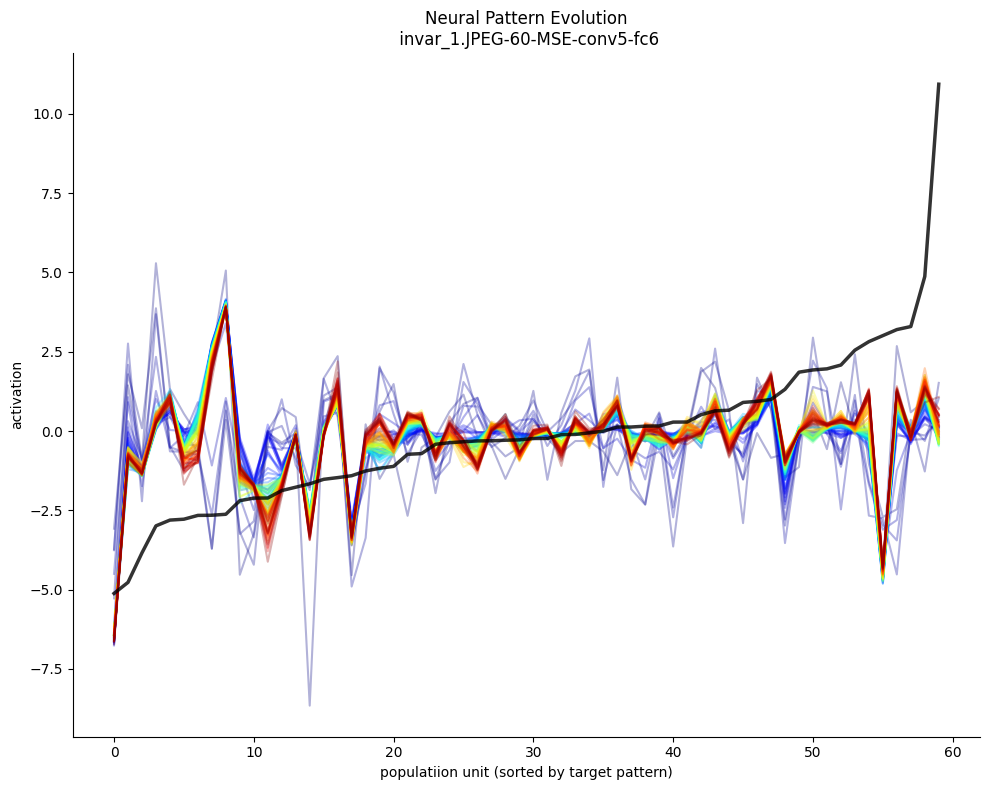

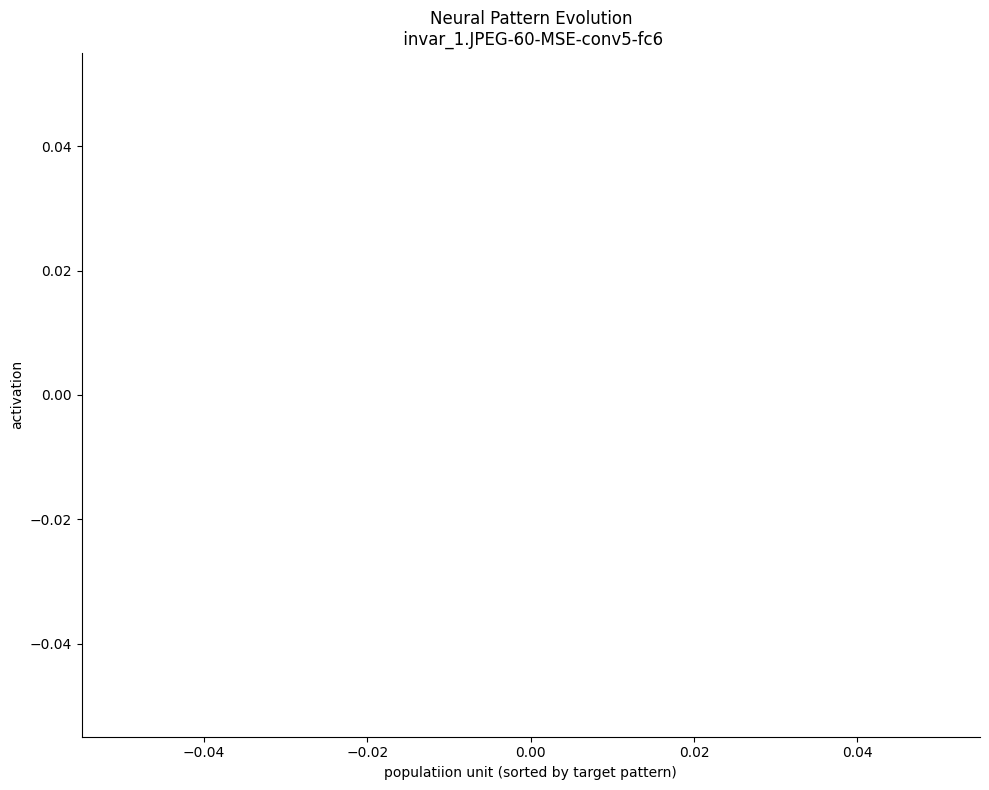

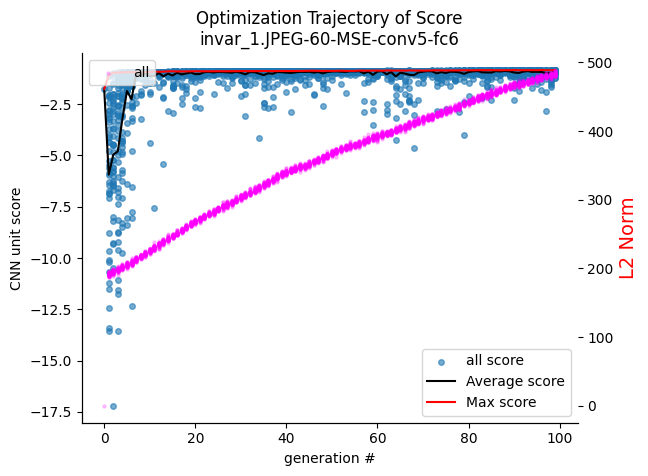

In [59]:
# random shuffle of the target activation matrix
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\big_data_set"

net_name = "alexnet" # corenet_s, resnet50, resnet50_linf_8, alexnet, vgg16, vgg16_bn, vgg19, vgg19_bn
layer_name = ['.features.Conv2d8']#'.BatchNorm2dbn3', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "conv5"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = round(60*1)
score_method = "MSE"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 21

targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
               scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
#unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
#                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)
resf_images_actmat, ref_imgtsr_resized = encode_image(scorer_random, refimgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
popul_m, popul_s = set_normalizer(resf_images_actmat)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
## BE CAREFULL WITH THIS-REMOVE IT LATER
#targ_actmat_shuff = np.random.permutation(targ_actmat[0])
#targ_actmat[0] = targ_actmat_shuff
# Set the value of k (number of elements to permute)
k = popsize
# Randomly choose k indices
selected_indices = np.random.choice(len(targ_actmat[0]), k, replace=False)

complementary_indices = np.setdiff1d(np.arange(len(targ_actmat[0])), selected_indices)
# normalize the targ_actmat
targ_actmat_norm = (targ_actmat - popul_m) / popul_s
# Create a copy of the array with only selected elements
selected_elements = targ_actmat_norm[0][selected_indices]
# Shuffle the selected elements
shuffled_selected_elements = np.random.permutation(selected_elements)
# add noise to the selected elements
# shuffled_selected_elements = selected_elements + np.random.normal(0, 2*np.std(selected_elements), selected_elements.shape)
# Replace the selected elements in the original array with the shuffled ones
targ_actmat_norm[0][selected_indices] = shuffled_selected_elements
# Un-normalize the targ_actmat
targ_actmat = (targ_actmat_norm * popul_s) + popul_m


##
print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=True, popul_m=popul_m, popul_s=popul_s)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel+" mean")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())
figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
figh = visualize_popul_act_evol(actmat_all[:, selected_indices], generations, targ_actmat[:, selected_indices], titlestr=title_str)
figh = visualize_popul_act_evol(actmat_all[:, complementary_indices], generations, targ_actmat[:, complementary_indices], titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()

In [4]:
# print all the refimgnms and their indices
for i, nm in enumerate(refimgnms):
    print(i, nm)

0 ecoset_10.JPEG
1 ecoset_11.JPEG
2 ecoset_12.JPEG
3 ecoset_14.JPEG
4 ecoset_16.JPEG
5 ecoset_26.JPEG
6 ecoset_31.JPEG
7 ecoset_33.JPEG
8 ecoset_49.JPEG
9 ecoset_7.JPEG
10 imagenet_116.JPEG
11 imagenet_14.JPEG
12 imagenet_18.JPEG
13 imagenet_26.JPEG
14 imagenet_35.JPEG
15 imagenet_5.JPEG
16 imagenet_52.JPEG
17 imagenet_58.JPEG
18 imagenet_7.JPEG
19 imagenet_8.JPEG
20 imagenet_83.JPEG
21 invar_1.JPEG
22 invar_1_flipped.JPEG
23 invar_2.JPEG
24 invar_2_rotated.JPEG
25 invar_3.JPEG
26 invar_3_flipped.JPEG
27 invar_3_rotated.JPEG
28 invar_4.JPEG
29 invar_4_flipped.JPEG
30 n05716342_1492.JPEG
31 n08524735_17105.JPEG


Layer .features.Conv2d8 Sampled 256 units from feature tensor of shape (256, 13, 13)
Gaussian Fitting center (110.9, 111.8)
 Cov mat XX 814.5 YY 855.4 XY 15.0
act mat shape:  (1, 256)
act mat shape:  (1, 256)


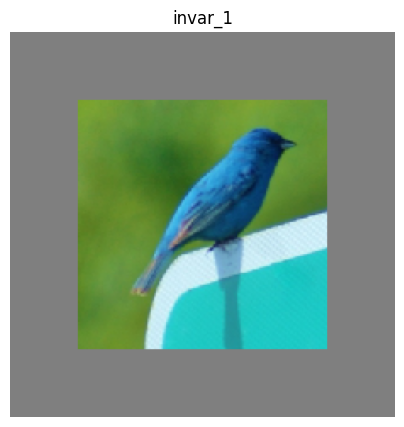

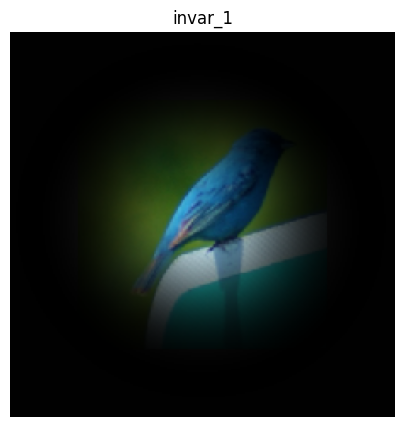

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
init score -74.756 (0.000)
:-------------------->  invar_1.JPEG-256-MSE-conv5-fc6 evol finished! best score: -44.602
plot not saved


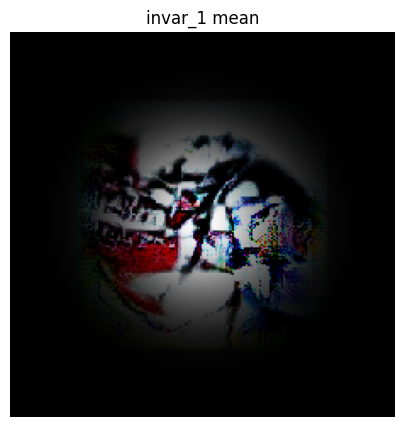

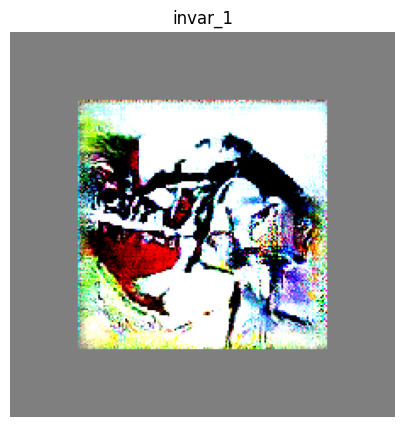

final MSE score:  0.098611414
Cleanuping...
Cleanup hooks done.
Cleanup done.


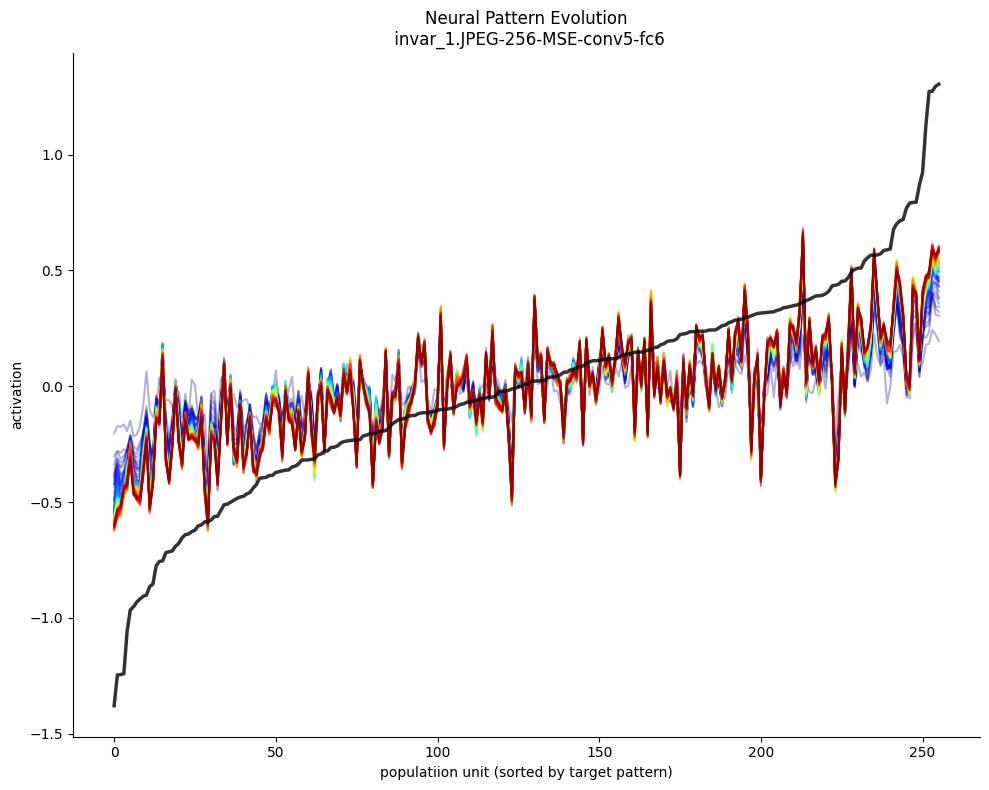

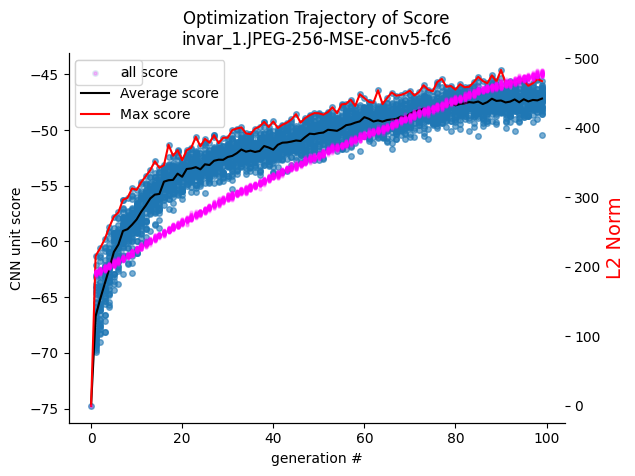

In [40]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\big_data_set"

net_name = "alexnet_untrained" # corenet_s, resnet50, resnet50_linf_8, alexnet, vgg16, vgg16_bn, vgg19, vgg19_bn
layer_name = ['.features.Conv2d8']#'.BatchNorm2dbn3', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "conv5"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = round(256*1)
score_method = "MSE"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 21 # id for intial image
dist_image_id  = 23 # id for distination image

targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
               scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
#unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
#                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)
resf_images_actmat, ref_imgtsr_resized = encode_image(scorer_random, refimgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
popul_m, popul_s = set_normalizer(resf_images_actmat)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
dist_image_actmat, dist_image_imgtsr_resized = encode_image(scorer_random, refimgtsr[dist_image_id:dist_image_id + 1], key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
## moving the inital image responce toward the distination image responce
moving_ratio = 1 
act_mat_diff = dist_image_actmat[0] - targ_actmat[0]
# normalize the act mat diff with popul_m and popul_s
act_mat_diff_norm = (act_mat_diff - popul_m) / popul_s
# normalize the act mats with with popul_m and popul_s
targ_actmat_norm = (targ_actmat - popul_m) / popul_s
dist_image_actmat_norm = (dist_image_actmat - popul_m) / popul_s
# shuffel the act mat diff norm
act_mat_diff_norm[0] = np.random.permutation(act_mat_diff_norm[0])
# move the targ_actmat_norm toward the dist_image_actmat_norm
targ_actmat_norm[0] = targ_actmat_norm[0] + moving_ratio * act_mat_diff_norm[0]
# move the targ_actmat_norm back to the original scale
targ_actmat = targ_actmat_norm * popul_s + popul_m + moving_ratio*popul_m

##
print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=True, popul_m=popul_m, popul_s=popul_s)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel+" mean")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())
figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
#figh = visualize_popul_act_evol(actmat_all[:, selected_indices], generations, targ_actmat[:, selected_indices], titlestr=title_str)
#figh = visualize_popul_act_evol(actmat_all[:, complementary_indices], generations, targ_actmat[:, complementary_indices], titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()

In [31]:
act_mat_diff

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [67]:
act_mat_diff = dist_image_actmat[0] - targ_actmat[0]
# normalize the act mat diff with popul_m and popul_s
act_mat_diff_norm = (act_mat_diff - popul_m) / popul_s
# shuffel the act mat diff norm


In [74]:
act_mat_diff_norm[0] = np.random.permutation(act_mat_diff_norm[0])


Layer .features.Conv2d8 Sampled 256 units from feature tensor of shape (256, 13, 13)
Gaussian Fitting center (110.4, 111.5)
 Cov mat XX 601.7 YY 589.4 XY -3.0
act mat shape:  (1, 256)
act mat shape:  (1, 256)


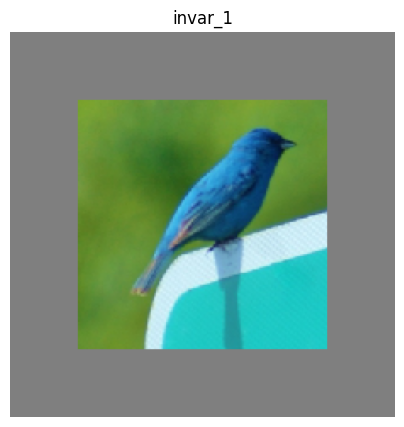

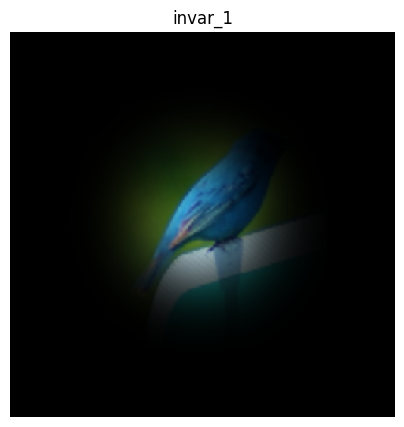

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
init score -0.798 (0.000)
:-------------------->  invar_1.JPEG-256-MSE-conv5-fc6 evol finished! best score: -0.190
plot not saved


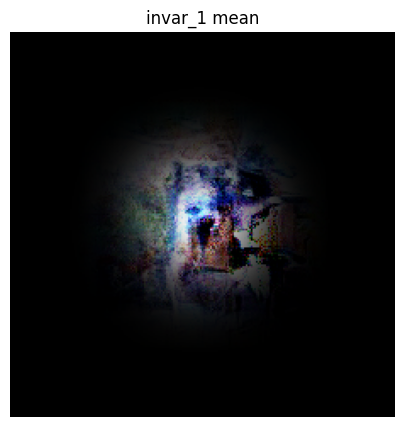

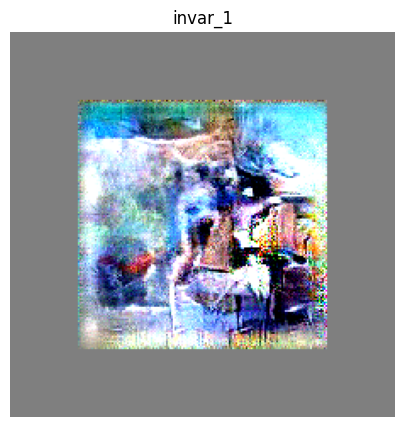

final MSE score:  12.114914
Cleanuping...
Cleanup hooks done.
Cleanup done.


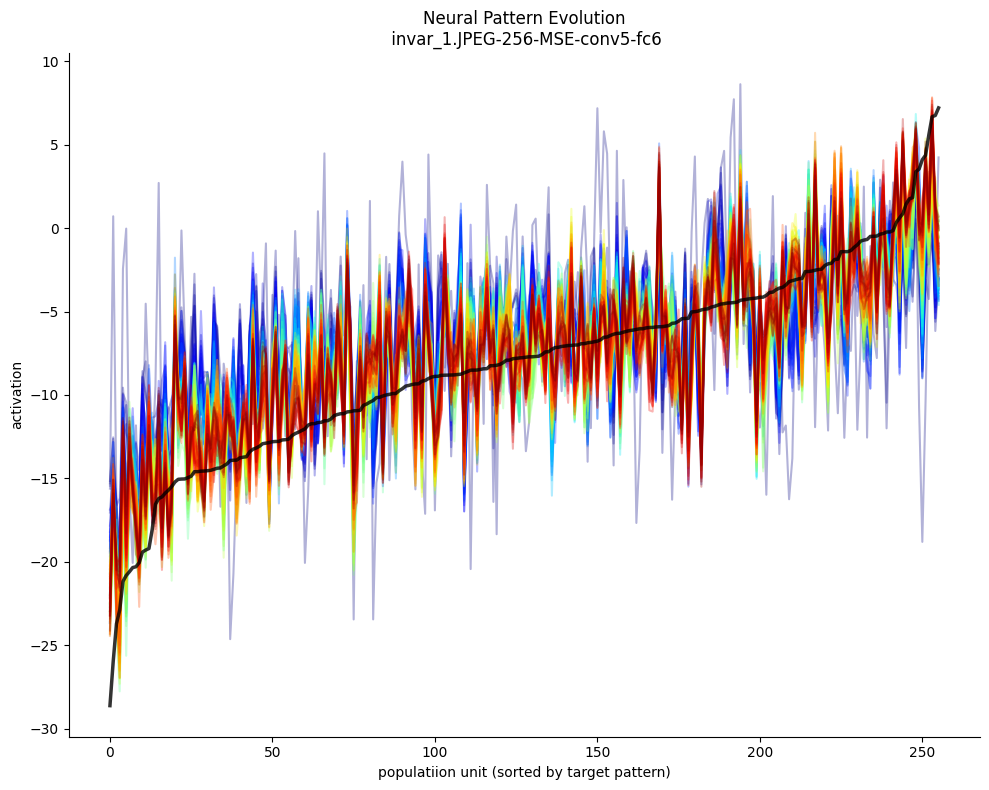

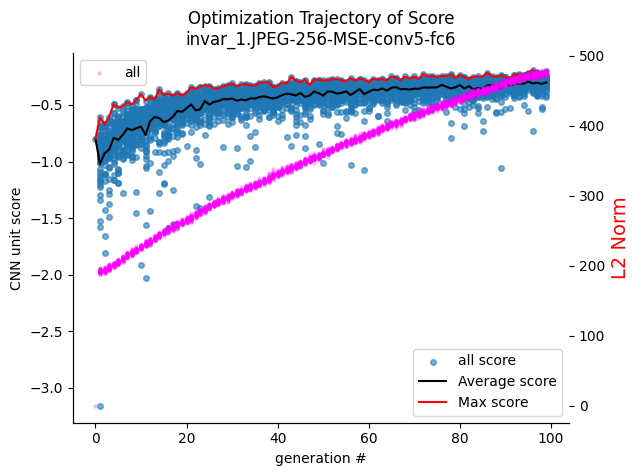

In [23]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\big_data_set"

net_name = "alexnet" # corenet_s, resnet50, resnet50_linf_8, alexnet, vgg16, vgg16_bn, vgg19, vgg19_bn
layer_name = ['.features.Conv2d8']#'.BatchNorm2dbn3', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "conv5"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = round(256*1)
score_method = "MSE"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 23 # id for intial image
dist_image_id_1  = 23 # id for distination image
dist_image_id_2  = 31 # id for distination image

targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
               scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
#unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
#                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)
resf_images_actmat, ref_imgtsr_resized = encode_image(scorer_random, refimgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
popul_m, popul_s = set_normalizer(resf_images_actmat)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
dist_image_actmat_1, dist_image_imgtsr_resized_1 = encode_image(scorer_random, refimgtsr[dist_image_id_1:dist_image_id_1 + 1], key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
dist_image_actmat_2, dist_image_imgtsr_resized_2 = encode_image(scorer_random, refimgtsr[dist_image_id_2:dist_image_id_2 + 1], key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
## finde the midle point between the tree vectors
targ_actmat = (targ_actmat + dist_image_actmat_1 + dist_image_actmat_2) / 3

##
print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=True, popul_m=popul_m, popul_s=popul_s)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel+" mean")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())
figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
#figh = visualize_popul_act_evol(actmat_all[:, selected_indices], generations, targ_actmat[:, selected_indices], titlestr=title_str)
#figh = visualize_popul_act_evol(actmat_all[:, complementary_indices], generations, targ_actmat[:, complementary_indices], titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()